In [1]:
#Extracting contact matrix
import cooler
import numpy as np

# 1) Open your .cool file
dir = '/oscar/data/larschan/shared_data/aguilera_cortez_et_al_2025/00_microc_matrices/cool_matrices/1kb/'
clr = cooler.Cooler(dir + "S2_gfpi.1kb_res.mcool::/resolutions/1000")

# 2) Pull out the *raw* contact‐count matrix as a NumPy array
#    (by default matrix() returns balanced; balance=False gives raw counts)
full_mat = clr.matrix(balance=False)[:]
# full_mat[:100]

# 3a) If you want a 2D matrix with everything *below* the diagonal zeroed:
upper_mat = np.triu(full_mat, k=0)    # k=0 includes diagonal; k=1 skips it
# upper_mat[:100]

# 3b) If you'd rather have a 1-D vector of all upper‐triangle entries above the diag:
i, j = np.triu_indices(full_mat.shape[0], k=1)
upper_vals = full_mat[i, j]

#full_mat, upper_mat, and upper_vals all already saved as .npy file



In [1]:
"""
Preprocessing the data. Merged necessary data tables into a single x_df that contains epigenetic factors and labels.
Creates and X and Y tensor to represent all epigenetic values and labels respectively
"""
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler

epi_dir = '/oscar/data/larschan/shared_data/bind_gps/chipseq/histone_mods_and_GA_factors.feature_matrix.1kb_res.tsv'
features_df = pd.read_csv(epi_dir, sep='\t')

labels_dir = '/oscar/data/larschan/shared_data/bind_gps/labels/autosomal_mre_vs_xchr_mre_labels.1kb_res.tsv'
labels_df = pd.read_csv(labels_dir, sep='\t')


"""
Commented out in order to have x_df and full_mat be the same shape.
No more rounding and filtering out rows
"""
# feature_cols = features_df.columns.difference(["chr", "start", "end", "labels"])
# features_df[feature_cols] = features_df[feature_cols].round(3)
# features_df = features_df.drop_duplicates(subset=feature_cols)
# merged_df = pd.merge(features_df, labels_df, on=["chr", "start", "end"])
# x_df = merged_df[merged_df["chr"] == "chrX"].copy()

merged_df = pd.merge(features_df, labels_df, on=["chr", "start", "end"])
x_df = merged_df[merged_df["chr"] == "chrX"].copy()
#This dataframe combines the epigenetic factor dataset with labels dataset, and changes the 2 labels into 1s
x_df['labels'] = x_df['labels'].replace(2, 1)

feature_cols = features_df.columns.difference(["chr", "start", "end", "labels"])
scaler = StandardScaler()
X_np = scaler.fit_transform(x_df[feature_cols].values)
X = torch.tensor(X_np, dtype=torch.float32)
Y = torch.tensor(x_df['labels'].values, dtype=torch.long)

full_mat = np.load("full_mat.npy")


In [2]:
# nonzero_entries = full_mat[full_mat > 0]

# threshold = np.percentile(nonzero_entries, 90) #returns 2
# #print(f"90th percentile threshold: {threshold}") #threshold becomes 2, anything below gets dropped

# #To manually choose the threshold, uncomment line below
# threshold = 50

# full_mat_thresholded = np.where(full_mat >= threshold, full_mat, 0)

# full_mat_thresholded = np.minimum(full_mat_thresholded, full_mat_thresholded.T)
full_mat_thresholded = []

def make_threshold(threshold_val, full_mat, use_percentile=False, percentile=None):
    
    if use_percentile:
        nonzero_entries = full_mat[full_mat > 0]
        threshold = np.percentile(nonzero_entries, percentile)
    else:
        threshold = threshold_val
        
    print("Current threshold: ", threshold)
    full_mat_thresholded = np.where(full_mat >= threshold, full_mat, 0)
    full_mat_thresholded = np.minimum(full_mat_thresholded, full_mat_thresholded.T)
    
    


In [3]:
"""
Converting contact matrix, epigenetic factors, and labels into a single graph representation where
nodes are individual genomic bins, edges are interactions between bins (weighted by number of connections),
node attributes are epigenetic factors, and binary labels for each node (0=no mre, 1=mre)
"""
import torch_geometric
from scipy import sparse
from torch_geometric.utils import from_scipy_sparse_matrix
from torch_geometric.data import Data

sparse_full_mat_file = sparse.csr_matrix(full_mat_thresholded)
#sparse_full_mat_file = sparse.csr_matrix(full_mat)
edge_index, edge_weight = from_scipy_sparse_matrix(sparse_full_mat_file) #edge_index stores bins (i, just) and edge_weights stores the raw counts between them

data = torch_geometric.data.Data(x=X, edge_index=edge_index, edge_attr=edge_weight, y=Y) #each node has index, features data.x[node_index], and label data.y[node_index]



In [4]:
"""
Preparing data and masks that will be used when training/testing
"""

from sklearn.model_selection import train_test_split

node_indices = np.arange(data.num_nodes)
labels_np = data.y.numpy()

#train_test_split already shuffles for us, no need to do it manually
train_idx, other_idx, train_labels, other_labels = train_test_split(node_indices, labels_np, stratify=labels_np, test_size=0.3, random_state=42)
val_idx, test_idx, val_labels, test_labels = train_test_split(other_idx, other_labels, stratify=other_labels, test_size=0.5, random_state=42)

train_idx = torch.tensor(train_idx, dtype=torch.long)
val_idx = torch.tensor(val_idx, dtype=torch.long)
test_idx = torch.tensor(test_idx, dtype=torch.long)

train_mask = torch.zeros(data.num_nodes, dtype=bool)
val_mask = torch.zeros(data.num_nodes, dtype=bool)
test_mask = torch.zeros(data.num_nodes, dtype=bool)
train_mask[train_idx] = True
val_mask[val_idx] = True
test_mask[test_idx] = True




In [5]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN_classification(nn.Module):
    
    def __init__(self, graph_conv_layer_sizes, lin_layer_sizes, dropout=0.5, class_weights=None):
        super(GCN_classification, self).__init__()
        
        self.dropout= dropout
        self.class_weights = class_weights
        
        self.gcn_layers = nn.ModuleList()
        for i in range(len(graph_conv_layer_sizes)-1):
            in_dim = graph_conv_layer_sizes[i]
            out_dim = graph_conv_layer_sizes[i+1]
            self.gcn_layers.append(GCNConv(in_dim, out_dim))
            
        self.lin_layers = nn.ModuleList()
        for i in range(len(lin_layer_sizes)-1):
            in_dim = lin_layer_sizes[i]
            out_dim = lin_layer_sizes[i+1]
            self.lin_layers.append(nn.Linear(in_dim, out_dim))
            
            
    def forward(self, x, edge_index, edge_weight=None, train_status=False):
        
        for gcn in self.gcn_layers:
            x = gcn(x, edge_index, edge_weight=edge_weight)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=train_status)
            
        for i, lin in enumerate(self.lin_layers):
            x = lin(x)
            if i != (len(self.lin_layers) - 1):
                x = F.relu(x)
                
        return x
    
    
    def calc_softmax_pred(self, logits):
        
        softmax = F.softmax(logits, dim=1)
        pred = torch.argmax(softmax, dim=1)
        return softmax, pred
    
    
    def loss(self, logits, labels):
        
        return F.cross_entropy(logits, labels, weight=self.class_weights)
        #return F.cross_entropy(logits, labels)
            
        
        

In [6]:

import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv

class GAT_classification(nn.Module):
    
    def __init__(self, gat_conv_layer_sizes, num_heads=4, dropout=0.5, class_weights=None):
    
        super(GAT_classification, self).__init__()
        self.dropout = dropout
        self.class_weights = class_weights
        self.heads = num_heads

        self.gat_layers = nn.ModuleList()
        in_dim = gat_conv_layer_sizes[0]
        for i in range(len(gat_conv_layer_sizes) - 2):
            out_dim = gat_conv_layer_sizes[i+1]
            self.gat_layers.append(GATv2Conv(in_dim, out_dim, heads=self.heads, concat=True))
            in_dim = out_dim*self.heads
        self.gat_layers.append(GATv2Conv(in_dim, gat_conv_layer_sizes[-1], heads=1, concat=False))
        self.final_dropout = nn.Dropout(p=self.dropout)
        self.classifier = nn.Linear(gat_conv_layer_sizes[-1], 2)
        
    def forward(self, x, edge_index, train_status=True):
        
        for gat in self.gat_layers[:-1]:
            x = gat(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=train_status)
        x = self.gat_layers[-1](x, edge_index)
        x = self.final_dropout(x)
        x = self.classifier(x)
        
        return x
    
    def calc_softmax_pred(self, logits):
        
        softmax = F.softmax(logits, dim=1)
        pred = torch.argmax(softmax, dim=1)
        return softmax, pred
    
    
    def loss(self, logits, labels):
        
        return F.cross_entropy(logits, labels, weight=self.class_weights)
        
        

In [7]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, precision_recall_curve, auc

def train_model_classification(model, graph, max_epochs, learning_rate, train_mask, val_mask, optimizer, model_type=""):
    
    train_loss_list = []
    train_AUROC_vec = []
    train_acc_vec = []
    val_loss_list = []
    val_AUROC_vec = []
    val_acc_vec =[]
    
    for e in range(max_epochs):
        
        model.train()
        optimizer.zero_grad() #preventing old gradients from accumulating
        
        if model_type == "GCN":
            output = model(graph.x, graph.edge_index, edge_weight=graph.edge_weight, train_status=True)
        elif model_type == "GAT":
            output = model(graph.x, graph.edge_index, train_status=True)
        else:
            raise ValueError(f"Unsupported model_type: {model_type}")
        
        train_output = output[train_mask]
        train_labels = graph.y[train_mask]
        
        train_loss = model.loss(train_output, train_labels)
        train_loss.backward()
        optimizer.step()
        train_loss_list.append(train_loss.item())
        
        #Calculating AUC metrics and validation loss
        model.eval()
        with torch.no_grad():
            if model_type == "GCN":
                logits = model(graph.x, graph.edge_index, edge_weight=graph.edge_weight, train_status=False)
            elif model_type == "GAT":
                logits = model(graph.x, graph.edge_index, train_status=False)
            else:
                raise ValueError(f"Unsupported model_type: {model_type}")
            
            val_output = logits[val_mask]
            val_labels = graph.y[val_mask]
            
            val_loss = model.loss(val_output, val_labels)
            val_loss_list.append(val_loss.item())
            
            val_probs, val_pred = model.calc_softmax_pred(val_output)
            val_probs_np = val_probs[:, 1].numpy() #getting the probabilities from the positive class (MRE)
            val_labels_np = val_labels.numpy()
            val_AUROC = roc_auc_score(val_labels_np, val_probs_np)
            val_AUROC_vec.append(val_AUROC)
            
            
            val_acc = accuracy_score(val_labels_np, val_pred.numpy())
            val_acc_vec.append(val_acc)
            
            
            train_probs, train_pred = model.calc_softmax_pred(train_output)
            train_probs_np = train_probs[:, 1].numpy()
            train_labels_np = train_labels.numpy()
            train_AUROC = roc_auc_score(train_labels_np, train_probs_np)
            train_AUROC_vec.append(train_AUROC)
            
            train_acc = accuracy_score(train_labels_np, train_pred.numpy())
            train_acc_vec.append(train_acc)
            
            if e % 10 == 0 or e == max_epochs - 1:
                print(f"Epoch {e} | Train Loss: {train_loss.item():.4f} | Train AUROC: {train_AUROC:.4f} | Val Loss: {val_loss.item():.4f} | Val AUROC: {val_AUROC:.4f}")
            
    return train_loss_list, val_loss_list, train_AUROC_vec, val_AUROC_vec, train_acc_vec, val_acc_vec

    

In [9]:
def eval_model_classification(model, graph, test_mask, use_threshold=False, custom_threshold=None, model_type=""):
    
    model.eval()
    
    with torch.no_grad():
        if model_type == "GCN":
            logits = model(graph.x, graph.edge_index, edge_weight=graph.edge_weight, train_status = False)
        elif model_type == "GAT":
            logits = model(graph.x, graph.edge_index, train_status=False)
        else:
            raise ValueError(f"Unsupported model_type: {model_type}")
        
        test_output = logits[test_mask]
        test_labels = graph.y[test_mask]
        
        if use_threshold:
            test_probs = F.softmax(test_output, dim=1)
            probs_np = test_probs[:, 1].numpy()
            preds_np = (probs_np >= custom_threshold).astype(int)
        else: 
        
            test_probs, test_preds = model.calc_softmax_pred(test_output)
            probs_np = test_probs[:, 1].numpy()
            preds_np = test_preds.numpy()
        
#         #adding a custom threshold to predictions, normally any logit above 0.5 is predicted as 1
#         test_probs = F.softmax(test_output, dim=1)
#         probs_np = test_probs[:, 1].numpy()
#         preds_np = (probs_np >= 0.58).astype(int)  # Use custom threshold
        
        labels_np = test_labels.numpy()
        
        test_AUROC = roc_auc_score(labels_np, probs_np)
        precision, recall, _ = precision_recall_curve(labels_np, probs_np)
        test_AUPR = auc(recall, precision)
        test_f1 = f1_score(labels_np, preds_np)
        test_precision = precision_score(labels_np, preds_np)
        test_recall = recall_score(labels_np, preds_np)
        
        test_acc = accuracy_score(labels_np, preds_np)
        
        print(f"\nTest AUROC: {test_AUROC:.4f}")
        print(f"Test AUPR : {test_AUPR:.4f}")
        print(f"F1 Score  : {test_f1:.4f}")
        print(f"Precision : {test_precision:.4f}")
        print(f"Recall    : {test_recall:.4f}")
        print(f"Accuracy  : {test_acc:.4f}")
        
    return test_AUROC, test_AUPR, test_acc, preds_np, labels_np, probs_np
        
        
    

GCN Model
Current threshold:  100
Epoch 0 | Train Loss: 0.6947 | Train AUROC: 0.4831 | Val Loss: 0.6875 | Val AUROC: 0.5736
Epoch 10 | Train Loss: 0.6496 | Train AUROC: 0.6451 | Val Loss: 0.6483 | Val AUROC: 0.6634
Epoch 20 | Train Loss: 0.6414 | Train AUROC: 0.6597 | Val Loss: 0.6416 | Val AUROC: 0.6714
Epoch 30 | Train Loss: 0.6366 | Train AUROC: 0.6677 | Val Loss: 0.6382 | Val AUROC: 0.6717
Epoch 40 | Train Loss: 0.6366 | Train AUROC: 0.6649 | Val Loss: 0.6357 | Val AUROC: 0.6765
Epoch 50 | Train Loss: 0.6345 | Train AUROC: 0.6704 | Val Loss: 0.6346 | Val AUROC: 0.6761
Epoch 60 | Train Loss: 0.6329 | Train AUROC: 0.6708 | Val Loss: 0.6337 | Val AUROC: 0.6775
Epoch 70 | Train Loss: 0.6327 | Train AUROC: 0.6709 | Val Loss: 0.6331 | Val AUROC: 0.6768
Epoch 80 | Train Loss: 0.6295 | Train AUROC: 0.6777 | Val Loss: 0.6327 | Val AUROC: 0.6761
Epoch 90 | Train Loss: 0.6295 | Train AUROC: 0.6773 | Val Loss: 0.6323 | Val AUROC: 0.6755
Epoch 99 | Train Loss: 0.6293 | Train AUROC: 0.6789 | Val

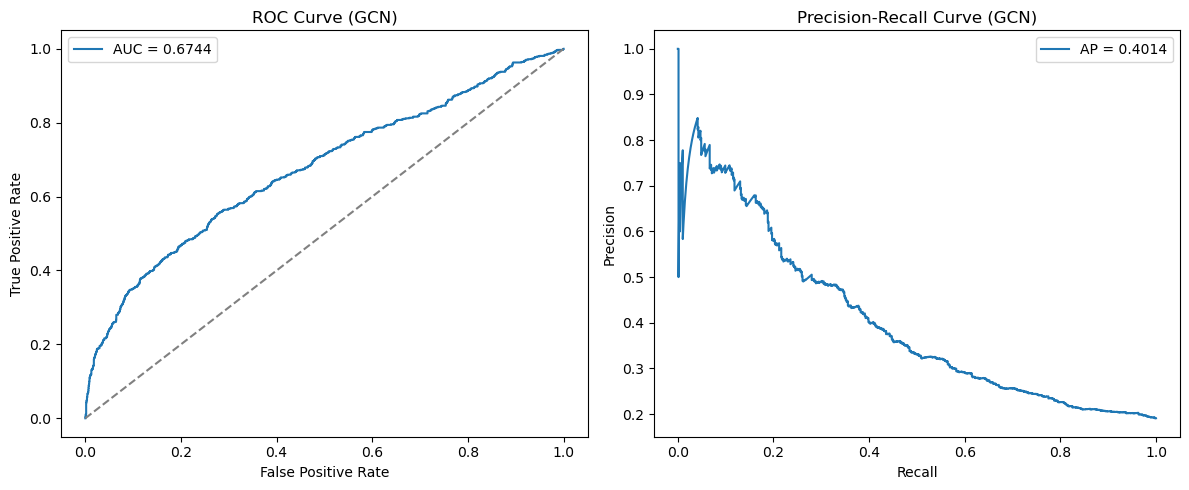

In [15]:
"""
Instantiating the GCN model
"""
print("GCN Model")
make_threshold(100, full_mat, False, 0)
graph_conv_layer_sizes = [X.shape[1], 256, 256]
lin_layer_sizes = [256, 128, 2]
#lin_layer_sizes = [256, 2], performed slightly worse


labels_np = data.y.numpy()
class_counts = np.bincount(labels_np)
total = class_counts.sum()
class_weights_np = total / (2* class_counts)
class_weights = torch.tensor(class_weights_np, dtype=torch.float32)

model = GCN_classification(graph_conv_layer_sizes=graph_conv_layer_sizes, lin_layer_sizes=lin_layer_sizes, dropout=0.5, class_weights=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=1.e-3)

train_loss_list, val_loss_list, train_AUROC_vec, val_AUROC_vec, train_acc_vec, val_acc_vec = train_model_classification(model, data, max_epochs=100, learning_rate=1e-3, train_mask=train_mask, val_mask=val_mask, optimizer=optimizer, model_type="GCN")
test_AUROC, test_AUPR, test_acc, preds_np, labels_np, probs_np = eval_model_classification(model, data, test_mask, model_type="GCN")
plot_auroc_aupr(probs_np, labels_np, "GCN")


In [46]:
print(class_weights)

tensor([0.6181, 2.6171])


GAT Model
Current threshold:  100
Model hyperparameters: gat_conv_layer_sizes = [11, 256, 128, 64], num_heads = 3, dropout = 0.5, lr = 1e-3
Epoch 0 | Train Loss: 0.7216 | Train AUROC: 0.4910 | Val Loss: 0.6925 | Val AUROC: 0.5277
Epoch 10 | Train Loss: 0.6681 | Train AUROC: 0.6029 | Val Loss: 0.6554 | Val AUROC: 0.6471
Epoch 20 | Train Loss: 0.6569 | Train AUROC: 0.6305 | Val Loss: 0.6462 | Val AUROC: 0.6648
Epoch 30 | Train Loss: 0.6496 | Train AUROC: 0.6439 | Val Loss: 0.6430 | Val AUROC: 0.6697
Epoch 40 | Train Loss: 0.6459 | Train AUROC: 0.6515 | Val Loss: 0.6412 | Val AUROC: 0.6727
Epoch 50 | Train Loss: 0.6447 | Train AUROC: 0.6539 | Val Loss: 0.6394 | Val AUROC: 0.6731
Epoch 60 | Train Loss: 0.6410 | Train AUROC: 0.6586 | Val Loss: 0.6385 | Val AUROC: 0.6729
Epoch 70 | Train Loss: 0.6401 | Train AUROC: 0.6630 | Val Loss: 0.6379 | Val AUROC: 0.6731
Epoch 80 | Train Loss: 0.6386 | Train AUROC: 0.6622 | Val Loss: 0.6375 | Val AUROC: 0.6729
Epoch 90 | Train Loss: 0.6376 | Train AURO

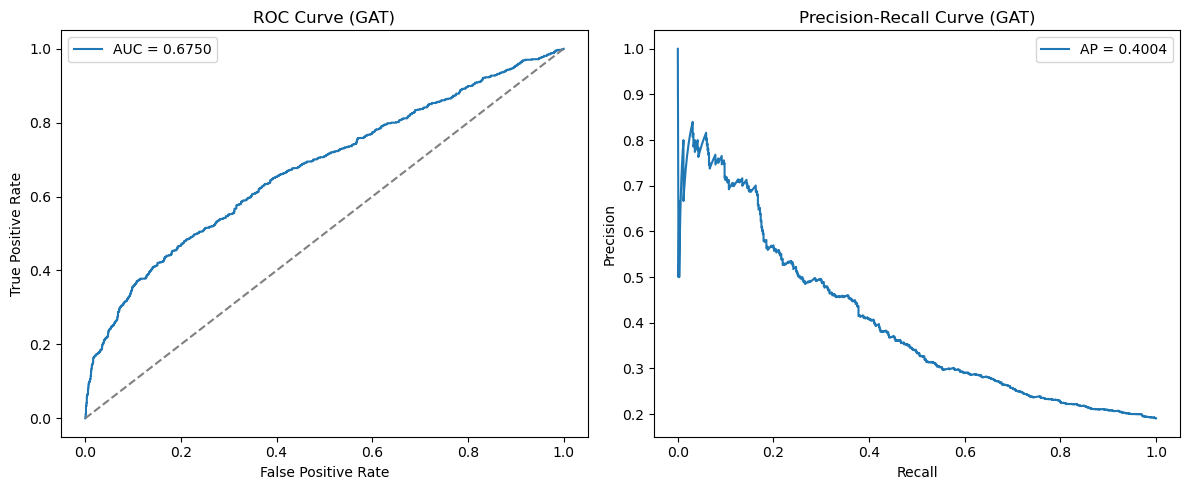

In [17]:
"""
Instantiating the GAT model
"""
print("GAT Model")
make_threshold(100, full_mat, False, 0)
gat_conv_layer_sizes = [X.shape[1], 256, 128, 64]

print(f"Model hyperparameters: gat_conv_layer_sizes = {gat_conv_layer_sizes}, num_heads = 3, dropout = 0.5, lr = 1e-3" )

model = GAT_classification(gat_conv_layer_sizes=gat_conv_layer_sizes, num_heads=2, dropout=0.5, class_weights=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=5.e-4)

train_loss_list, val_loss_list, train_AUROC_vec, val_AUROC_vec, train_acc_vec, val_acc_vec = train_model_classification(model, data, max_epochs=100, learning_rate=1e-3, train_mask=train_mask, val_mask=val_mask, optimizer=optimizer, model_type="GAT")
test_AUROC, test_AUPR, test_acc, preds_np, labels_np, probs_np = eval_model_classification(model, data, test_mask, model_type="GAT")
plot_auroc_aupr(probs_np, labels_np, "GAT")


In [ ]:
from torch_geometric.explain import Explainer, GNNExplainer
import matplotlib.pyplot as plt

explainer = Explainer(model=model, 
                      algorithm=GNNExplainer(epochs=200), 
                      explanation_type='model', 
                      node_mask_type='attributes',
                      edge_mask_type='object',
                      model_config=dict(mode='multiclass_classification', #not binary because the model outputs a vector of size 2, two logits for each class
                                       task_level='node',
                                       return_type='raw')
                     )
node_index = 2000
explanation = explainer(data.x, data.edge_index, index=node_index)
print(f'Generated explanations in {explanation.available_explanations}')

node_feature_importance = explanation.node_mask[node_index]
#plt.bar(range(len(explanation.node_mask)), explanation.node_mask.numpy())

plt.bar(range(len(node_feature_importance)), node_feature_importance.numpy())
plt.xlabel('Feature index')
plt.ylabel('Importance')
plt.title(f"Node Feature Importance for node {node_index}")
plt.show()


# path = 'feature_importance.png'
# explanation.visualize_feature_importance(path, top_k=10)
# print(f"Feature importance plot has been saved to '{path}'")

# path = 'subgraph.pdf'
# explanation.visualize_graph(path)
# print(f"Subgraph visualization plot has been saved to '{path}'")

In [8]:
"""
Sanity check print statements
"""
# print(x_df.shape)
# print(X.shape) #23543 nodes, 11 features
# print(Y.shape)
# print(full_mat.shape)

# print(edge_index.shape) #3993026 num edges
# print(edge_weight.shape) 

print(np.unique(data.y.numpy(), return_counts=True)) #19045 0s and 4498 1s (23543 total), so 80.9% 0s and 19.1% 1s
print(class_weights)

from numpy import count_nonzero
unique_vals, counts = np.unique(full_mat, return_counts=True)

for val, count in zip(unique_vals, counts):
    print(f"Value {val}: {count} occurrences")
    
sparsity = 1.0 - (count_nonzero(full_mat) / float(full_mat.size))
print(sparsity)

(array([0, 1]), array([19045,  4498]))
tensor([0.6181, 2.6171])


In [19]:
print(feature_cols)
print(feature_cols[5])
num_nodes = data.x.size(0)
print(f'Number of nodes: {num_nodes}')


Index(['clamp', 'gaf', 'h3k27ac', 'h3k27me3', 'h3k36me3', 'h3k4me1', 'h3k4me2',
       'h3k4me3', 'h3k9me3', 'h4k16ac', 'psq'],
      dtype='object')
h3k4me1
Number of nodes: 23543


In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc

def plot_auroc_aupr(probs, labels, model_name=""):
    
    fpr, tpr, _ = roc_curve(labels, probs)
    roc_auc = auc(fpr, tpr)
    
    precision, recall, _ = precision_recall_curve(labels, probs)
    pr_auc = auc(recall, precision)
    
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
    plt.plot([0, 1], [0, 1], '--', color='gray')
    plt.title(f"ROC Curve ({model_name})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label=f"AP = {pr_auc:.4f}")
    plt.title(f"Precision-Recall Curve ({model_name})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
def run_n_times(num_runs, max_epochs, model_type=""):
    
    all_train_loss